In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs
from shapely.geometry import Point
import geopandas as gpd

from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, make_scorer, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

from functions import plot_processed_cdd_data

model_columns=["totalx_max","cape_max","w_min","p80.162_max","d_min","q_max","cp_max","tciw_max","deg0l_max","sp_mean"]
model_parameters={
    "objective": "binary:logistic",
    #"class_weight": "balanced",
    "random_state": 43,
    "learning_rate": 0.05, 
    "max_depth": 5, 
    "n_estimators": 100
}

In [15]:
### Functions ### 

def calculate_weights_simple(probability_inference,alpha,power=1):
    alphas=alpha*np.ones(len(probability_inference))
    return (1 / (1 - alphas*probability_inference))**power

def undersampling_train(X,y,desired_ratio=6):
    num_ones= int(sum(y == 1)) # keeps 4 times more 0s than ones
    undersampler = RandomUnderSampler(sampling_strategy={0: num_ones*desired_ratio,1:num_ones})
    X_resampled, y_resampled = undersampler.fit_resample(X,y)
    return X_resampled, y_resampled

def max_mcc(y_test,y_pred,print_scores=True):
    # Find the threshold that maximizes MCC
    thresholds=np.linspace(0,1,21)
    mcc_values = [matthews_corrcoef(y_test, (y_pred > t).astype(int)) for t in thresholds]
    max_mcc_index = mcc_values.index(max(mcc_values))
    max_mcc_threshold = thresholds[max_mcc_index]
    max_mcc = max(mcc_values)

    if print_scores==True:
        print(f'Max MCC: {max_mcc:.3f} (Threshold: {max_mcc_threshold:.3f})')

    return max_mcc_threshold, max_mcc

def remove_no_hail_events(df):
    # Group by 'latitude' and 'longitude' and sum the 'Hail_Event' column for each group
    hail_event_sums = df.groupby(['latitude', 'longitude'])['Hail_Event'].sum().reset_index()
    
    # Filter to keep only latitudes and longitudes where hail events occurred (sum > 0)
    hail_event_locations = hail_event_sums[hail_event_sums['Hail_Event'] > 0]
    
    # Merge or filter the original dataframe to keep only the lat/lon pairs with hail events
    return pd.merge(df, hail_event_locations[['latitude', 'longitude']], on=['latitude', 'longitude'])

def calculate_f_transfer(y_pred,y_obs,threshold):
    y_pred_binary=(y_pred> threshold).astype(int)
    P = y_obs.sum()
    TP = (y_pred_binary * y_obs).sum()
    r = TP/P
    p = y_pred_binary.sum()/y_pred_binary.shape[0]       
    f_pu = r**2/p

    return f_pu

def calculate_best_f_transfer(y_pred,y_obs,print_scores=True):
    thresholds=np.linspace(0,1,51)
    f_pus=np.zeros(51)
    for index,threshold in enumerate(thresholds):
        f_pu=calculate_f_transfer(y_pred,y_obs,threshold)
        f_pus[index]=f_pu

        
    max_f_index = f_pus.tolist().index(max(f_pus))
    max_f_threshold = thresholds[max_f_index]
    max_f = max(f_pus)

    if print_scores==True:
        print(f'Max F_modified: {max_f:.3f} (Threshold: {max_f_threshold:.3f})')

    return max_f, max_f_threshold
    
### Classes ###

class train_data():
    def __init__(self,path,train_years,test_years,columns,target_variable="Hail_Event",remove_areas_without_events=False):
        # Basic importing and reading
        self.path=path
        self.best_variables=columns
        self.train_years=train_years
        self.duplicate_variables=["latitude","longitude","year","month","day"]
        data=pd.read_parquet(path)
        self.dictionary_variables={
            "totalx_max":"Total-Totals Index",
            "cape_max":"CAPE",
            "w_min":"vertical velocity",
            "p80.162_max":" divergence of frozen water flux",
            "d_min":"divergence",
            "q_max":"specific humidity",
            "cp_max":"convective precipitation",
            "tciw_max":"Total Content of Ice Water",
            "deg0l_max":"freezing level",
            "sp_mean":"surface pressure",
        }
        
        # Removing areas with no events in the train dataset
        if remove_areas_without_events==True: 
            data = remove_no_hail_events(data)
            
        # Separatign data 
        data_train=data.loc[data.year.isin(train_years)]
        data_test=data.loc[data.year.isin(test_years)]
        X_train=data_train[self.best_variables].values
        X_test=data_test[self.best_variables].values
        y_train=data_train[target_variable]
        y_test=data_test[target_variable]
        #del(data,data_train,data_test)

        # Scaler
        scaler=StandardScaler()
        scaler.fit(X_train)
        X_train_scaled=scaler.transform(X_train)
        X_test_scaled=scaler.transform(X_test)

        # Undersampling
        X_train_scaled_resampled, y_train_resampled = undersampling_train(X_train_scaled,y_train)

        # Writting to class
        self.scaler=scaler
        self.data_train=data_train
        self.X_train_scaled_resampled=X_train_scaled_resampled
        self.X_train_scaled=X_train_scaled
        self.y_train_resampled=y_train_resampled
        self.X_test_scaled=X_test_scaled
        self.y_test=y_test

class inference_data():
    def __init__(self,path,years,columns,data_train,target_variable="Hail_Event",remove_areas_without_events=False):
        # Basic importing and reading
        self.best_variables=columns
        self.target_variable=target_variable
        self.duplicate_variables=["latitude","longitude","year","month","day"]
        data=pd.read_parquet(path)
        data=data.loc[data.year.isin(years)]
        if remove_areas_without_events==True:
            data = remove_no_hail_events(data)

        # Extracting, scaling, undersampling
        X_inference=data[self.best_variables].values
        y_inference=data[target_variable]
        X_inference_scaled=data_train.scaler.transform(X_inference)
        X_inference_scaled_resampled, y_inference_resampled = undersampling_train(X_inference_scaled,y_inference)
        self.X_inference_scaled=X_inference_scaled
        self.X_inference_scaled_resampled=X_inference_scaled_resampled
        self.data=data

    def study_covariate_shift(self):
        
        fig=plt.figure(figsize=(12,12))
        fig.subplots_adjust(hspace=0.35,wspace=0.3)
        
        for index,variable in enumerate(self.best_variables):
            values_train_1=data_train.data_train.loc[data_train.data_train[self.target_variable]==1][variable]
            values_train_0=data_train.data_train.loc[data_train.data_train[self.target_variable]==0][variable]
            values_inference_1=self.data.loc[self.data[self.target_variable]==1][variable]
            values_inference_0=self.data.loc[self.data[self.target_variable]==0][variable]
            
            plt.subplot(3,4,index+1)
            plt.boxplot([values_train_0,values_inference_0,values_train_1,values_inference_1],positions=[0.5,1,2,2.5],patch_artist=True,whis=[0.5,99.5],widths=0.2,showfliers=False,labels=["train 0","inference 0","train 1","inference 1"])
            plt.xticks(rotation=30)
            plt.title(data_train.dictionary_variables[variable])
            plt.axvline(1.5,linestyle="--",color="k",linewidth=1)

        return fig

    def calculate_probability_train(self,data_train):
        """
        This function trains a ML model to calculate the probability that a given datapoint is in the inferecne region
        """

        # Train data is asinged a 0 as y, while inference data is asigned a 1
        y_inference_positive=np.ones(len(self.X_inference_scaled_resampled))
        y_inference_negative=np.zeros(len(data_train.X_train_scaled_resampled))
        X_covariate_shift=np.concatenate([self.X_inference_scaled_resampled,data_train.X_train_scaled_resampled])
        y_covariate_shift=np.concatenate([y_inference_positive,y_inference_negative])
        print("Number of train data points: ",len(y_inference_negative))
        print("Number of inference data points: ",len(y_inference_positive))

        # Setting and training model
        classifier_domain=LogisticRegression(C= 1., max_iter=1200, warm_start=True, multi_class="ovr", class_weight='balanced')
        poly_classifier_domain = make_pipeline(PolynomialFeatures(degree=2), classifier_domain)
        poly_classifier_domain.fit(X_covariate_shift, y_covariate_shift)
        inference_probability=poly_classifier_domain.predict_proba(X_covariate_shift)[:,1]
        inference_events=poly_classifier_domain.predict(X_covariate_shift)
        self.poly_classifier_domain=poly_classifier_domain

        # Calculating probability inerence in train dataset
        inference_probability_train_dataset=poly_classifier_domain.predict_proba(data_train.X_train_scaled)[:,1]
        data_train.data_train["probability_inference"]=inference_probability_train_dataset
        data_train_grouped=data_train.data_train.groupby(["latitude","longitude"])["probability_inference"].mean().reset_index()

        # Calculating probability of inference in train resampled dataset
        data_train.inference_probability_train_dataset_resampled=poly_classifier_domain.predict_proba(data_train.X_train_scaled_resampled)[:,1]

        # Calculating probability inerence in inference dataset
        inference_probability_inference_dataset=poly_classifier_domain.predict_proba(self.X_inference_scaled)[:,1]
        self.data["probability_inference"]=inference_probability_inference_dataset
        data_inference_grouped=self.data.groupby(["latitude","longitude"])["probability_inference"].mean().reset_index()
        
        # printing some metrics
        accuracy = accuracy_score(y_covariate_shift, inference_events)
        auc_roc=roc_auc_score(y_covariate_shift, inference_probability)
        print("AUC ROC: ",auc_roc)
        print("Accuracy at 0.5: ",accuracy)
        
        ### Plotting some basic evaluation ###
        fig=plt.figure(figsize=(15, 4))
        fig.subplots_adjust(wspace=0.2)
        
        plt.subplot(141)
        plt.hist(inference_probability[y_covariate_shift==0],density=True,alpha=0.75,label="Train",bins=np.linspace(0,1,51))
        plt.hist(inference_probability[y_covariate_shift==1],density=True,alpha=0.75,label="Inference",bins=np.linspace(0,1,51))
        plt.xlabel("Probability of inference domain")
        plt.ylabel("Number")
        plt.title("Accuracy: "+str(round(accuracy,2)),fontsize=12)
        plt.legend()

        plt.subplot(142)
        plt.title('Calibration Plot')
        CalibrationDisplay.from_predictions(y_covariate_shift, inference_probability,n_bins=20,ax=plt.gca())

        plt.subplot(143, projection=crs.PlateCarree())
        ax=plt.gca()
        plt.title('probability of inference \n in train region')
        plot_processed_cdd_data(ax,data_train_grouped,"probability_inference",alpha=0.75,vmax=1,zoom=6,colorbar_name="mean probability")

        plt.subplot(144, projection=crs.PlateCarree())
        ax=plt.gca()
        plt.title('probability of inference \n in inference region')
        plot_processed_cdd_data(ax,data_inference_grouped,"probability_inference",alpha=0.75,vmax=1,zoom=6,colorbar_name="mean probability")
        
        plt.show()

        return data_train

class classifier_xgboost():
    def __init__(self,data_train,parameters,data_inference=False,alpha=1,power=1):
        # Add data inference by setting data ingerence
        # If data_inference is provided, weights are computed
        if not data_inference==False:
            weights=calculate_weights_simple(data_train.inference_probability_train_dataset_resampled,alpha,power=power)#_simple

        if data_inference==False:
            weights=np.ones(len(data_train.X_train_scaled_resampled))            
        
        # Reading and training
        classifier = XGBClassifier(**model_parameters)
        print("training...")
        classifier.fit(data_train.X_train_scaled_resampled, data_train.y_train_resampled,sample_weight=weights)
        print("model trained")

        # Validation
        y_test_predicted=classifier.predict_proba(data_train.X_test_scaled)[:, 1]
        print("Scores on training region (test)")
        max_mcc_threshold, max_mcc_value=max_mcc(data_train.y_test,y_test_predicted)

        # Saving
        self.classifier=classifier

    def make_inference(self,data_inference,plot_inference_map=False,calibration_factor=False,vmax=10):
        
        data_inference.data["probability"]=self.classifier.predict_proba(data_inference.X_inference_scaled)[:,1]

        # Calculating MCC y F' for inference
        print("Scores on inference region")
        max_mcc_threshold, max_mcc_value=max_mcc(data_inference.data[data_inference.target_variable].values,data_inference.data["probability"].values)
        max_f, max_f_threshold = calculate_best_f_transfer(data_inference.data["probability"].values,data_inference.data[data_inference.target_variable].values)

        if plot_inference_map==True:
            data_inference.data["probability_calibrated"]=data_inference.data["probability"]*calibration_factor
            data_inference_grouped_yearly=data_inference.data.groupby(["latitude","longitude"])[["probability_calibrated",data_inference.target_variable]].sum().reset_index()
            data_inference_grouped_yearly["probability_calibrated"]=data_inference_grouped_yearly["probability_calibrated"]/len(data_inference.data.year.unique())
            data_inference_grouped_yearly[data_inference.target_variable]=data_inference_grouped_yearly[data_inference.target_variable]/len(data_inference.data.year.unique())
            
            plt.subplot(121, projection=crs.PlateCarree())
            ax=plt.gca()
            plot_processed_cdd_data(ax,data_inference_grouped_yearly,"probability_calibrated",alpha=0.75,vmax=calibration_factor,zoom=6,colorbar_name="mean probability")

            plt.subplot(122, projection=crs.PlateCarree())
            ax=plt.gca()
            plot_processed_cdd_data(ax,data_inference_grouped_yearly,data_inference.target_variable,alpha=0.75,vmax=vmax,zoom=6,colorbar_name="mean probability")

            
            plt.show()
        return data_inference, max_mcc_value, max_f

In [11]:
path_central_europe="/home/jovyan/data/koios/transfer_learning/koios_data_central_europe.parquet"
calibration_factor=0.15

training_data=train_data(path_central_europe,np.arange(2016,2023),[2023],model_columns,remove_areas_without_events=True)
training_data_for_inference=inference_data(path_central_europe,np.arange(2023,2024),model_columns,training_data)

In [4]:
base_classifier=classifier_xgboost(training_data,model_parameters)

training...
model trained
Scores on training region (test)
Max MCC: 0.247 (Threshold: 0.750)


Scores on inference region
Max MCC: 0.226 (Threshold: 0.750)
Max F_modified: 16.767 (Threshold: 0.700)


/tmp/ipykernel_2109/3213519189.py:42: RuntimeWarning: invalid value encountered in scalar divide
  f_pu = r**2/p


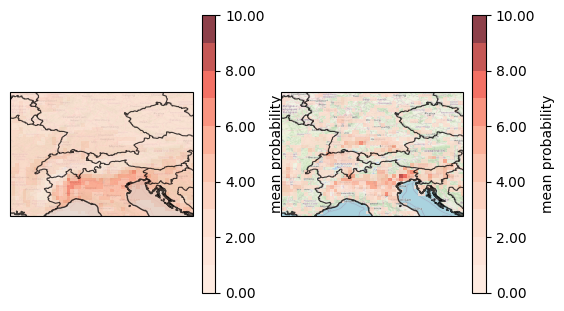

In [16]:
data_inference, max_mcc_value, max_f=base_classifier.make_inference(training_data_for_inference,plot_inference_map=True,calibration_factor=calibration_factor)

<Axes: >

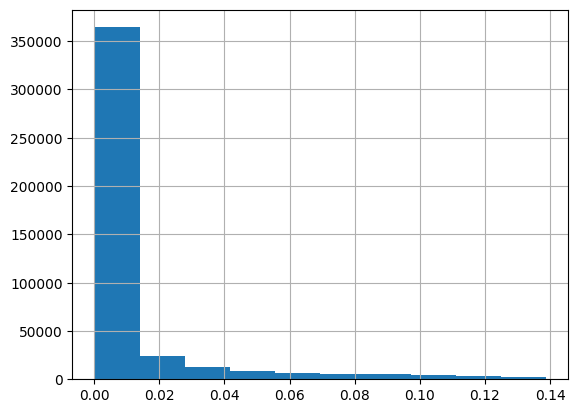

In [14]:
#### MIRAR POR QUE NO SE PINTAN BIEN LAS COLOBARS DE LAS PROBABILIDADES